In [ ]:
import pickle
import os
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
from vlm_reward_test import *

clip_model_list = ['RN50', 'ViT-B-32', 'ViT-B-16', 'ViT-H-14', 'ViT-L-14', 'ViT-L-14-336']

envs = ['CartPole-v1', 'MountainCar-v0']

question_dict = {
    'CartPole-v1': 'pole vertically upright on top of the cart',
    'Pendulum-v1': 'pendulum in the upright position',
    # 'MountainCar-v0': 'a car at the peak of the mountain, next to the yellow flag',
    'MountainCar-v0': 'The image is a white background with a curved line drawn on it. The line is shaped like a wave, and it appears to be a graph or a representation of a curve. There is a small car or truck at the end of the curve, giving the impression that it is traveling along the curved path.',
    # 'MountainCar-v0': 'lower position of the car is better',
}

baseline_dict = {
    'CartPole-v1': 'pole and cart',
    'Pendulum-v1': 'pendulum',
    'MountainCar-v0': 'a car in the mountain',
    # 'MountainCar-v0': 'The image features a graph with a curve that has a small black dot on it. The curve is steep, and the dot is located near the bottom of the curve. The graph is displayed on a white background, making the curve and the dot stand out prominently.',
}



ModuleNotFoundError: No module named 'gymnasium'

In [ ]:
def get_result(env_name, clip_model, question, baseline, samples=50, alpha=1.0, folder='test'):
    env = gym.make(f'{env_name}', render_mode='rgb_array')
    env.reset()
    if env_name == 'CartPole-v1':
        rendered_images, rewards, vars = discretize_and_render_states_cartpole(env, num_states_per_dimension=samples)
    elif env_name == 'Pendulum-v1':
        pass
        # rendered_images, rewards = discretize_and_render_states_pendulum(env, num_states_per_dimension=samples)
    elif env_name == 'MountainCar-v0':
        rendered_images, rewards, vars = discretize_and_render_states_mountaincar(env, num_states_per_dimension=samples)
    env.close()

    result_dict = {'rendered_images': rendered_images, 'rewards': rewards, 'vars': vars}

    vlm_rewards = []
    rewarder = ClipReward(clip_model)

    for image in rendered_images:
        vlm_reward = get_reward_from_image(rewarder, image, question, baseline, alpha=alpha)
        vlm_rewards.append(vlm_reward)
        print(vlm_reward)

    result_dict['vlm_rewards'] = vlm_rewards

    os.makedirs(folder, exist_ok=True)
    with open(f'{folder}/{env_name}_{clip_model}_alpha{alpha}_results.pkl', 'wb') as file:
        pickle.dump(result_dict, file)

In [ ]:
save_folder = 'test'
for env in envs:
    for clip_model in clip_model_list:
        question = question_dict[env]
        baseline = baseline_dict[env]  
        get_result(env, clip_model, question, baseline, samples=50, alpha=1.0, folder=save_folder)  
        
        with open(f"{save_folder}/{env}_prompt.txt", "w") as file:
            # Write the first string followed by a newline character
            file.write(f"target: {question}" + "\n")
            
            # Write the second string
            file.write(f"baseline: {baseline}")


In [3]:

def load_results(path, env='CartPole-v1', show_frame=False):
    # Read pkl file
    with open(path, 'rb') as file:
        data = pickle.load(file)

    # Assuming the pkl file has a key "images" which is a list of image file paths
    images = data["rendered_images"]
    rewards = data["rewards"]
    vlm_rewards = data["vlm_rewards"]
    var_values = data["vars"]

    print('# of samples: ', len(images))
    vars_dict = {'CartPole-v1': 'pole angle', 'Pendulum-v1': 'pendulum angle', 'MountainCar-v0': 'car position'}
    x_label = vars_dict[env]
    plt.title(path.split('_')[0])
    plt.xlabel(x_label)
    plt.ylabel('VLM reward')
    plt.plot(var_values, vlm_rewards)
    plt.show()

    if show_frame:
        # Load and plot each image
        for img, r, vr, v in zip(images, rewards, vlm_rewards, var_values):
            print(f'var value: {v}, vlm reward: {vr}')
            plt.imshow(img)
            plt.show()



In [ ]:
# enumerate all results
env='CartPole-v1'
alpha=1.0

# print prompt
with open(f"{save_folder}/{env}_prompt.txt", "r") as file:
    # Write the first string followed by a newline character
    print(file.read())
    

for clip_model in clip_model_list:
    path = f'test/{env}_{clip_model}_alpha{alpha}_results.pkl'
    print('Clip model: ', clip_model, ', alpha: ', alpha)
    load_results(path, env=env, show_frame=False)
    print('\n')



# of samples:  50


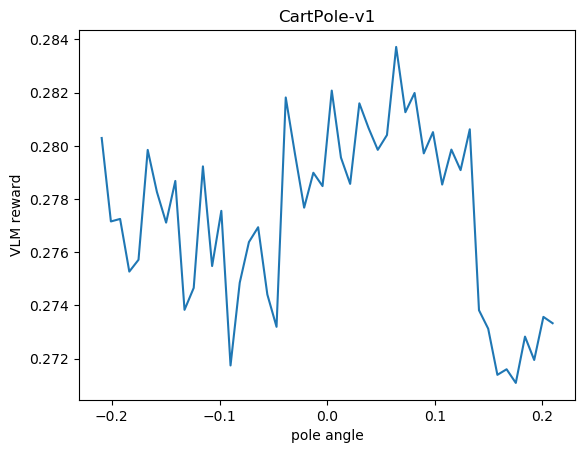

In [6]:
load_results('CartPole-v1_results.pkl', 'CartPole-v1', show_frame=False)